In [46]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
from pandas.plotting import lag_plot

[*********************100%***********************]  1 of 1 completed

Coefficient: 0.01995273202396561
Intercept: 6.969048741026389e-05
R-Squared: 0.0005185244154712887


Price,Adj Close,Close,High,Low,Open,Volume,Close + 1,Target,High_2prev,Bull_FVG,Bull_FVG_Val,Low_2prev,Bear_FVG,Bear_FVG_Val,Both_FVG,Predictions,Residuals
6,244.479996,244.479996,244.720001,244.449997,244.649994,14873,244.250000,-0.000941,245.012405,0,-0.000000,244.800003,1,-0.000327,-0.000327,6.316130e-05,0.001004
12,242.910004,242.910004,243.050003,242.059998,242.059998,6876,243.074997,0.000679,245.270004,0,-0.000000,243.899994,1,-0.003499,-0.003499,-1.281256e-07,-0.000679
13,243.074997,243.074997,243.899994,243.074997,243.179993,3056,242.199997,-0.003600,244.929993,0,-0.000000,244.270004,1,-0.001522,-0.001522,3.931831e-05,0.003639
15,242.735001,242.735001,242.735001,242.070007,242.669998,3063,242.095001,-0.002637,243.899994,0,-0.000000,243.074997,1,-0.001401,-0.001401,4.174291e-05,0.002678
21,241.179993,241.179993,241.179993,241.035004,241.035004,3137,241.389999,0.000871,242.320007,0,-0.000000,242.162506,1,-0.004074,-0.004074,-1.159249e-05,-0.000882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3184,259.424988,259.424988,259.674988,259.239990,259.674988,5414,259.559998,0.000520,260.274994,0,-0.000000,260.000000,1,-0.001253,-0.001253,4.469335e-05,-0.000476
3187,260.750000,260.750000,260.750000,260.130005,260.130005,3690,260.649994,-0.000384,259.929993,1,0.000767,259.454987,0,0.000000,0.000767,8.499553e-05,0.000469
3188,260.649994,260.649994,260.760010,260.600006,260.760010,3821,260.684998,0.000134,260.230011,1,0.001420,259.619110,0,0.000000,0.001420,9.801358e-05,-0.000036
3194,260.079987,260.079987,260.260010,260.000000,260.260010,5082,259.945007,-0.000519,260.894989,0,-0.000000,260.700012,1,-0.001692,-0.001692,3.593452e-05,0.000555


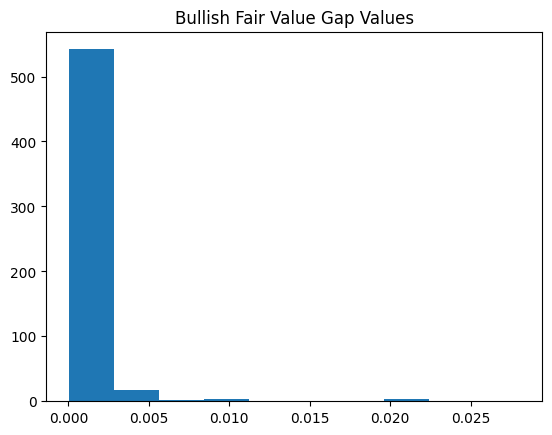

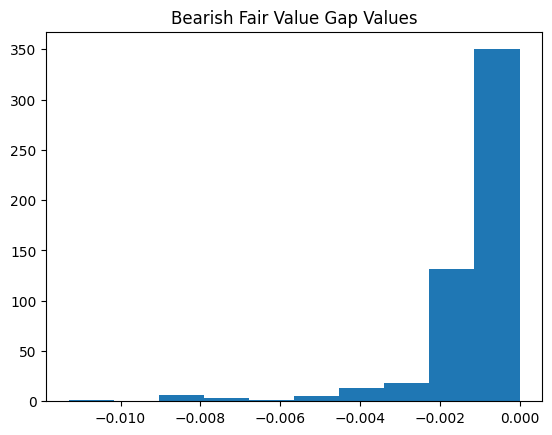

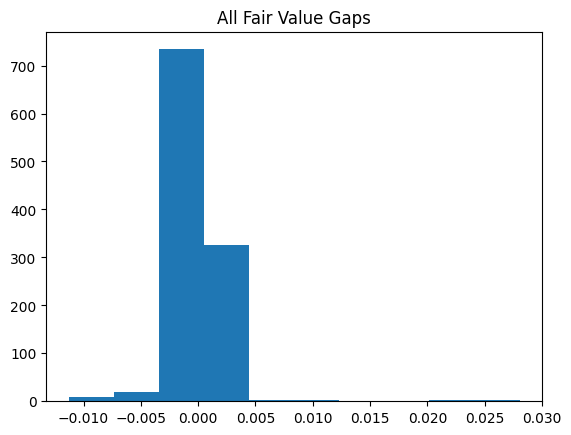

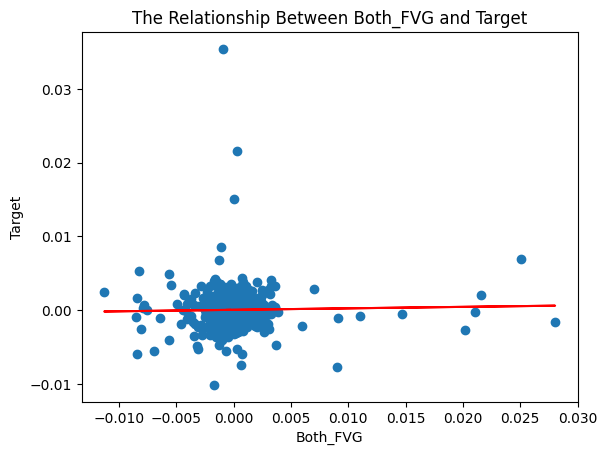

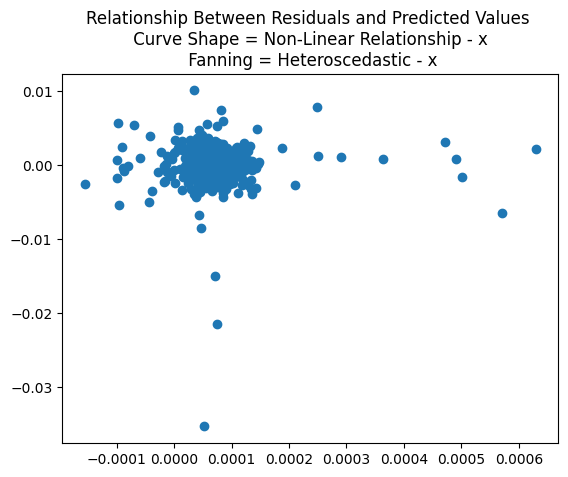

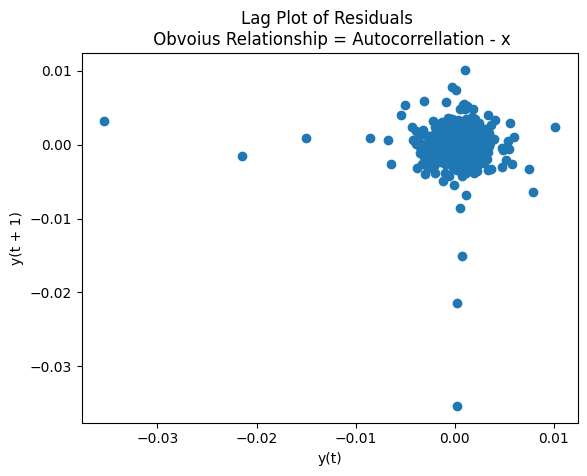

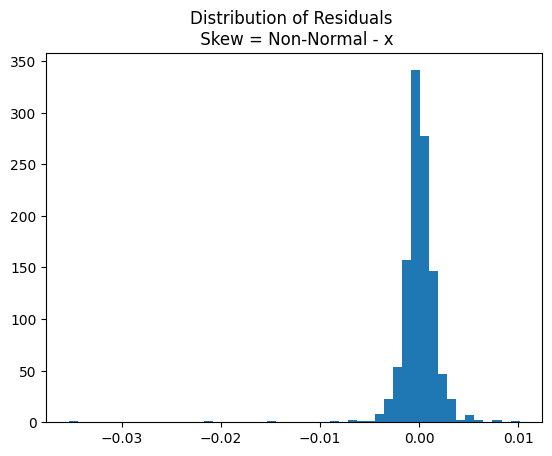

In [ ]:
TICKER = 'VMC'
INTERVAL='5m'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 1
STRATEGY = 'Both_FVG'

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, auto_adjust=False)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT):

    # what is the close price SHIFT days from now?
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    # what is the change in close price SHIFT days from now?
    df['Target'] = (df[f'Close + {shift}'] - df['Close']) / df['Close']

    return df

def bull_fvg(df):

    df['High_2prev'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    return df

def bear_fvg(df):

    df['Low_2prev'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    return df

def prepare_dataframe_for_regression(df):
    df = df[(df['Bull_FVG'] == 1) | (df['Bear_FVG'] == 1)].copy()
    df['Both_FVG'] = df['Bear_FVG_Val'] + df['Bull_FVG_Val']

    plt.figure()
    plt.hist(df['Both_FVG'])
    plt.title('All Fair Value Gaps')

    return df

def generate_regression_output(df, features=f'{STRATEGY}', target='Target'):

    subset = df[[features, target]].dropna()

    # reshape for sklearn
    X = subset[[features]].values # 2d
    y = subset[target].values # 1d

    model = sk.linear_model.LinearRegression()
    model.fit(X, y)

    # use the regression model to "predict" the target variable
    y_pred = model.predict(X)

    # what is the relationship between features and target?
    r2 = sk.metrics.r2_score(y, y_pred)

    # make coefficient variable
    coefficient = model.coef_[0]
    intercept = model.intercept_

    # coef, intercept, r2... mse later on
    print(f"Coefficient: {coefficient}")
    print(f"Intercept: {intercept}")
    print(f"R-Squared: {r2}")

    # plot a relationship between feature and target
    plt.figure()
    plt.title(f'The Relationship Between {features} and {target}')
    plt.scatter(X, y)
    plt.plot(X, y_pred, color='red', label=f'y = {coefficient:.2f}x + {intercept:.2f}')
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")

    return coefficient, intercept

def validate_regression_output(df, coef, intercept):

    # information necessary
    df['Predictions'] = coef * df[f'{STRATEGY}'] + intercept
    df['Residuals'] = df['Predictions'] - df['Target']

    # plot for linearity/homoscedasticity
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    plt.title('Relationship Between Residuals and Predicted Values \n ' \
        'Curve Shape = Non-Linear Relationship - x \n ' \
        'Fanning = Heteroscedastic - x')
    
    # plot for autocorrelations
    plt.figure()
    lag_plot(df['Residuals'].dropna())
    plt.title('Lag Plot of Residuals \n Obvoius Relationship = Autocorrellation - x')

    # plot for normality
    plt.figure()
    plt.hist(df['Residuals'], bins=50)
    plt.title('Distribution of Residuals \n Skew = Non-Normal - x')

    return df

def main():
    df = get_data()
    df = add_target(df)
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = prepare_dataframe_for_regression(df)
    fit_coef, fit_intercept = generate_regression_output(df)
    df = validate_regression_output(df, coef=fit_coef, intercept=fit_intercept)

    return df

df = main()
df